### Please install the required Python modules/SDKs

In [ ]:
! activate ai-azure-c1

import sys

sys.path.append("/opt/conda/envs/ai-azure-c1/lib/python3.8/site-packages")

### This demo uses the latest pillow package to show the rectangular bounding box around the face, so please upgrade the pillow package using the command below:

In [ ]:
!pip install Pillow==8.4

## Importing Useful Python Libraries or Packages

In [1]:
import datetime
import pandas as pd
from PIL import Image
import requests
import io
import glob, os, sys, time, uuid

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw

In [2]:
from azure.cognitiveservices.vision.face import FaceClient
from azure.cognitiveservices.vision.face.models import TrainingStatusType
from msrest.authentication import CognitiveServicesCredentials

## Accessing Specific Azure Resources 

In [3]:
AVKASH_FACE_KEY = "1a2396256acf47948e521ed1c2e3b557"
AVKASH_FACE_ENDPOINT = "https://face-detection-api1.cognitiveservices.azure.com/"

In [4]:
# Create a client
face_client = FaceClient(AVKASH_FACE_ENDPOINT, CognitiveServicesCredentials(AVKASH_FACE_KEY))

In [5]:
face_client.api_version

'1.0'

## Now, upload several images of your own to this workspace and modify the code below as needed

In [6]:
!ls digital-id*.jpg

digital-id.jpg


In [23]:
my_face_images = [file for file in glob.glob('*.jpg') if file.startswith("passport")]
print(my_face_images)

['passport.jpg']


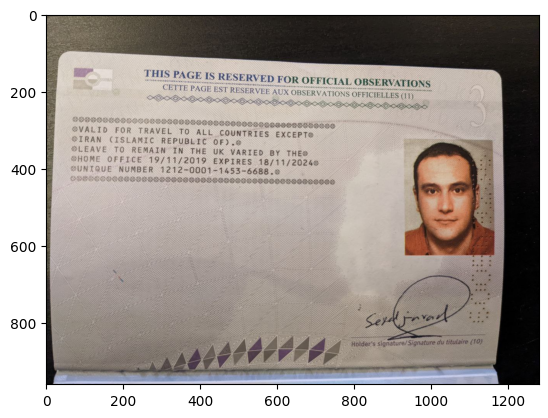

In [24]:
for img in my_face_images:
    with open(img, 'rb') as img_code:
        img_view_ready = Image.open(img_code)
        
        plt.figure()
        plt.imshow(img_view_ready)

# Creating Person Model Based on your face images

In [25]:
PERSON_GROUP_ID = str(uuid.uuid4())
person_group_name = 'group-name'

In [26]:
## This code is taken from Azure face SDK 
## ---------------------------------------
def build_person_group(client, person_group_id, pgp_name):
    print('Create and build a person group...')
    # Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
    print('Person group ID:', person_group_id)
    client.person_group.create(person_group_id = person_group_id, name=person_group_id)

    # Create a person group person.
    my_face = client.person_group_person.create(person_group_id, pgp_name)
    # Find all jpeg images of human in working directory.
    my_face_images = [file for file in glob.glob('*.jpg') if file.startswith("passport")]
    # Add images to a Person object
    for image_p in my_face_images:
        with open(image_p, 'rb') as w:
            client.person_group_person.add_face_from_stream(person_group_id, my_face.person_id, w)

    # Train the person group, after a Person object with many images were added to it.
    client.person_group.train(person_group_id)

    # Wait for training to finish.
    while (True):
        training_status = client.person_group.get_training_status(person_group_id)
        print("Training status: {}.".format(training_status.status))
        if (training_status.status is TrainingStatusType.succeeded):
            break
        elif (training_status.status is TrainingStatusType.failed):
            client.person_group.delete(person_group_id=PERSON_GROUP_ID)
            sys.exit('Training the person group has failed.')
        time.sleep(5)


In [27]:
build_person_group(face_client, PERSON_GROUP_ID, person_group_name)

Create and build a person group...
Person group ID: 10b32ed6-a052-478c-bddc-b182ce973353
Training status: running.
Training status: succeeded.


# Making sure the person model has faces and they all belong to the same person

In [28]:
'''
Detect all faces in query image list, then add their face IDs to a new list.
'''
def detect_faces(client, query_images_list):
    print('Detecting faces in query images list...')

    face_ids = {} # Keep track of the image ID and the related image in a dictionary
    for image_name in query_images_list:
        image = open(image_name, 'rb') # BufferedReader
        print("Opening image: ", image.name)
        time.sleep(5)

        # Detect the faces in the query images list one at a time, returns list[DetectedFace]
        faces = client.face.detect_with_stream(image)  

        # Add all detected face IDs to a list
        for face in faces:
            print('Face ID', face.face_id, 'found in image', os.path.splitext(image.name)[0]+'.jpg')
            # Add the ID to a dictionary with image name as a key.
            # This assumes there is only one face per image (since you can't have duplicate keys)
            face_ids[image.name] = face.face_id

    return face_ids

## Now, let's view the face-specific thumbnails 

In [29]:
ids = detect_faces(face_client, my_face_images)

Detecting faces in query images list...
Opening image:  passport.jpg
Face ID 2f7e735a-3e02-4387-a99a-6e6df72a609c found in image passport.jpg


In [30]:
ids

{'passport.jpg': '2f7e735a-3e02-4387-a99a-6e6df72a609c'}

### Verify that 2 random images from the list belong to the same person
- ### Note: Modify your image file name if you see fit.

In [35]:
# Verification example for faces of the same person.
verify_result = face_client.face.verify_face_to_face(ids['passport.jpg'], ids['human-face2.jpg'])

KeyError: 'human-face2.jpg'

In [33]:
if verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(verify_result.confidence))

NameError: name 'verify_result' is not defined

## Match face from ID card with face from Video Analyzer 

In [34]:
def show_image_in_cell(face_url):
    response = requests.get(face_url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(10,5))
    plt.imshow(img)
    plt.show()

In [ ]:
# Replace with your own image URL
dl_source_url = 'https://raw.githubusercontent.com/udacity/cd0461-building-computer-vision-solutions-with-azure-exercises/main/resources/ca-dl-sample.png'


In [ ]:
show_image_in_cell(dl_source_url)

In [ ]:
## -------
## Reading file locally
## -------
# If I had image file locally I would have used the following method
# dl_image = open('/your-local-file-system/udacity/cal-dl.png', 'rb')
# dl_faces = face_client.face.detect_with_stream(dl_image)  

In [36]:
dl_faces = face_client.face.detect_with_url(dl_source_url) 

NameError: name 'dl_source_url' is not defined

## View Face ID and then save it into the list of already saved Face IDs

In [ ]:
for face in dl_faces:
    print('Face ID', face.face_id, 'found in image', dl_source_url)
    # Add the ID to a dictionary with image name as a key.
    # This assumes there is only one face per image (since you can't have duplicate keys)
    ids['ca-dl-sample.png'] = face.face_id

## Now, you have (n + 1) Face IDs in your Face ID list

In [ ]:
ids

## Perform face verification between the 1 Face ID and the n Face IDs

In [ ]:
# Verification example for faces of the same person.
dl_verify_result = face_client.face.verify_face_to_face(ids['human-face4.jpg'], ids['ca-dl-sample.png'])

In [ ]:
if dl_verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(dl_verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(dl_verify_result.confidence))

In [ ]:
ids['ca-dl-sample.png']

In [ ]:
ids.values()

In [ ]:
dl_faces[0].face_rectangle.as_dict()

In [ ]:
# TAKEN FROM THE Azure SDK Sample
# Convert width height to a point in a rectangle
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))

In [ ]:
def drawFaceRectangles(source_file, detected_face_object) :
    # Download the image from the url
    response = requests.get(source_file)
    img = Image.open(BytesIO(response.content))
    # Draw a red box around every detected faces
    draw = ImageDraw.Draw(img)
    for face in detected_face_object:
        draw.rectangle(getRectangle(face), outline='red', width = 10)
    return img

In [ ]:
drawFaceRectangles(dl_source_url, dl_faces)

## Match Face ID from the face image URL with Person Model 

In [ ]:
# A list of Face ID
ids

In [ ]:
# Enter the face ID of ca-dl-sample.png from the output of the cell above
get_the_face_id_from_the_driving_license = 'ENTER FACE ID HERE'

In [ ]:
person_gp_results = face_client.face.identify([get_the_face_id_from_the_driving_license], PERSON_GROUP_ID)

In [ ]:
for result in person_gp_results:
    for candidate in result.candidates:
        print("The Identity match confidence is {}".format(candidate.confidence))